In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import hamiltonians as H
import utils
from scipy.linalg import eigh

%matplotlib inline

### Setup

In [2]:
# use nvidia gpu if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# only float32 tested
dtype = torch.float32
    
print("Device:", device)
print("Data type:", dtype)

Device: cuda
Data type: torch.float32


### Ring w/ 2 particles

In [3]:
# Hamiltonian Setup
N=5000
N_proj=20
g = 1
alpha=15

In [4]:
%time Hgen = H.H_ring_2particles(N, g)

CPU times: user 1.57 s, sys: 1.09 s, total: 2.66 s
Wall time: 2.28 s


In [5]:
%time eigs_t = torch.symeig(Hgen, eigenvectors=False).eigenvalues[:N_proj].cpu().numpy()
print(eigs_t)

CPU times: user 33.7 s, sys: 753 ms, total: 34.4 s
Wall time: 2.31 s
[2.91482389e-01 3.92793121e+01 5.59434357e+01 1.53479080e+02
 1.59596313e+02 3.38922516e+02 3.64801025e+02 6.24071106e+02
 6.50542419e+02 9.93366333e+02 1.00433594e+03 1.41179712e+03
 1.43850305e+03 1.94145947e+03 1.95154041e+03 2.52423462e+03
 2.54198169e+03 3.20865137e+03 3.21124951e+03 3.93736206e+03]


In [6]:
%time eigs_sp = eigh(Hgen.cpu().numpy())[0][:N_proj]
print(eigs_sp)

CPU times: user 41.7 s, sys: 286 ms, total: 42 s
Wall time: 2.92 s
[-1.6793566e+00  1.4831582e+01  8.0875336e+01  1.4691910e+02
  1.7994098e+02  3.6156131e+02  3.6156131e+02  6.2573633e+02
  6.4224719e+02  9.8897693e+02  1.0219988e+03  1.4182614e+03
  1.4347722e+03  1.9301005e+03  1.9466115e+03  2.5244941e+03
  2.5410054e+03  3.1849316e+03  3.2179536e+03  3.9444351e+03]


In [7]:
# the hamiltonian model
model = utils.Hamiltonian(Hgen, N, N_proj).to(device=device)

In [8]:
# loss function and optimizer
criterion = utils.Cost(N_proj, alpha)
optimizer = utils.optim.Rprop(model.parameters(), lr=0.1)

In [9]:
# optimization
n_iter=20000
n_print=500
its, errs, hps, ips, ts = utils.optimize(model, optimizer, criterion, n_iter, n_print, stop_early=True, rel_tol=0.0001, patience=3, show_progress=True)

[1] loss: 1705137982668.80004883. diff: 0.00000000. time: 0.0065
[501] loss: 574890172516.16503906. diff: -11302478101526.34960938. time: 1.1834
[1001] loss: 0.98395216. diff: -5748901725151.81054688. time: 2.3579
[1501] loss: 0.98015775. diff: -0.03794406. time: 3.5398
[2001] loss: 0.97905984. diff: -0.01097905. time: 4.7104
[2501] loss: 0.97844829. diff: -0.00611554. time: 5.8834
[3001] loss: 0.97802033. diff: -0.00427961. time: 7.0530
[3501] loss: 0.97772739. diff: -0.00292942. time: 8.2222
[4001] loss: 0.97752024. diff: -0.00207148. time: 9.3893
[4501] loss: 0.97736240. diff: -0.00157842. time: 10.5622
[5001] loss: 0.97723858. diff: -0.00123819. time: 11.7511
[5501] loss: 0.97713939. diff: -0.00099192. time: 12.9442
[6001] loss: 0.97705917. diff: -0.00080213. time: 14.1496
[6501] loss: 0.97698821. diff: -0.00070963. time: 15.3399
[7001] loss: 0.97692665. diff: -0.00061561. time: 16.5277
Early stopping criteria met.
Finished Training


In [10]:
eigs_sp

array([-1.6793566e+00,  1.4831582e+01,  8.0875336e+01,  1.4691910e+02,
        1.7994098e+02,  3.6156131e+02,  3.6156131e+02,  6.2573633e+02,
        6.4224719e+02,  9.8897693e+02,  1.0219988e+03,  1.4182614e+03,
        1.4347722e+03,  1.9301005e+03,  1.9466115e+03,  2.5244941e+03,
        2.5410054e+03,  3.1849316e+03,  3.2179536e+03,  3.9444351e+03],
      dtype=float32)

In [11]:
eigs_t

array([2.91482389e-01, 3.92793121e+01, 5.59434357e+01, 1.53479080e+02,
       1.59596313e+02, 3.38922516e+02, 3.64801025e+02, 6.24071106e+02,
       6.50542419e+02, 9.93366333e+02, 1.00433594e+03, 1.41179712e+03,
       1.43850305e+03, 1.94145947e+03, 1.95154041e+03, 2.52423462e+03,
       2.54198169e+03, 3.20865137e+03, 3.21124951e+03, 3.93736206e+03],
      dtype=float32)

In [12]:
eigs_approx = eigh(hps[-1].cpu().detach().numpy())[0][:N_proj]
eigs_approx

array([9.2197895e-01, 3.9478405e+01, 4.1450439e+01, 1.5791379e+02,
       1.5990594e+02, 3.5530566e+02, 3.5730261e+02, 6.3165997e+02,
       6.3373456e+02, 9.8918707e+02, 9.9682147e+02, 1.4436338e+03,
       1.5146726e+03, 2.0269005e+03, 2.4888479e+03, 2.5345261e+03,
       2.8741409e+03, 3.2441499e+03, 4.0445264e+03, 4.1298496e+03],
      dtype=float32)

In [13]:
def plot_rel_err(eigs, eigs_approx):
    plt.plot((eigs_approx - eigs)/eigs, 'o-')
    plt.hlines(0, 0, N_proj, linestyles='dashed')
    plt.xlabel = 'excitation number'
    plt.ylabel = 'error'

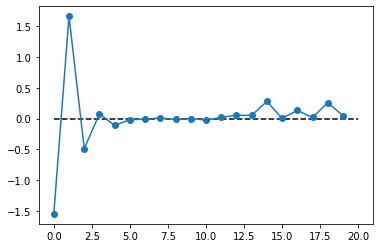

In [14]:
plot_rel_err(eigs_sp, eigs_approx)

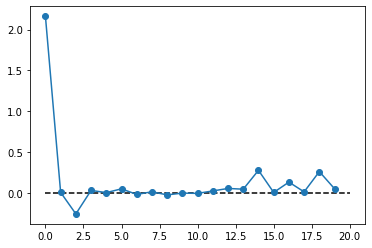

In [15]:
plot_rel_err(eigs_t, eigs_approx)

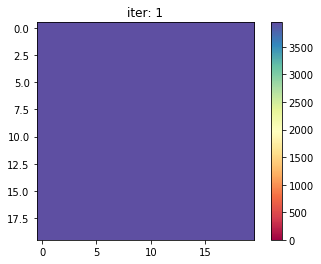

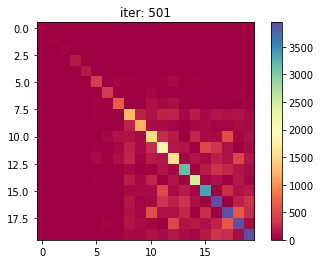

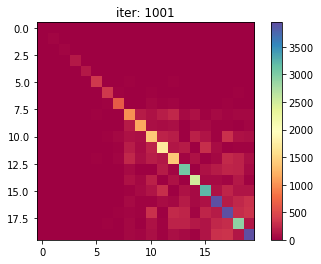

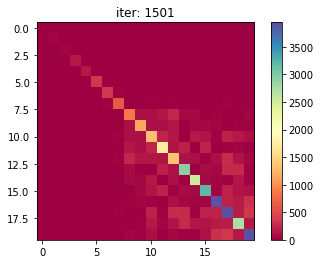

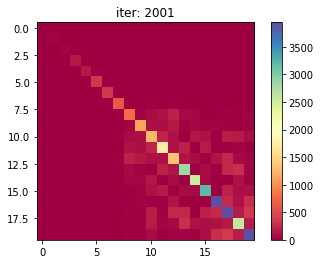

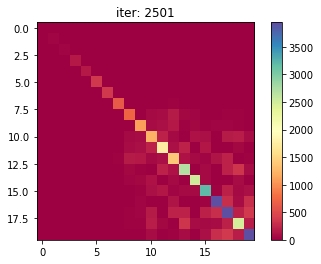

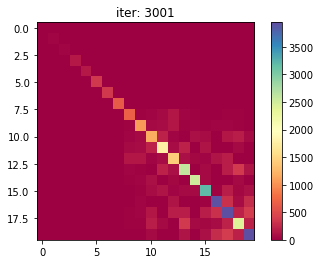

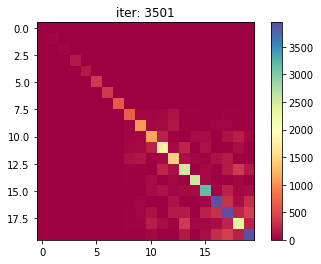

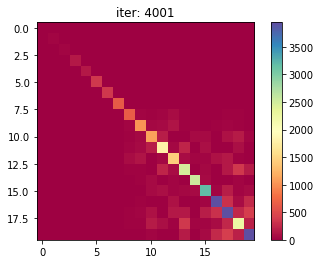

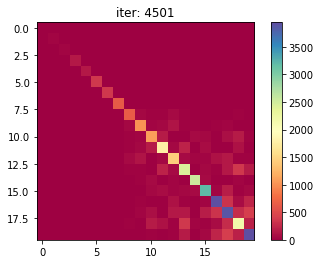

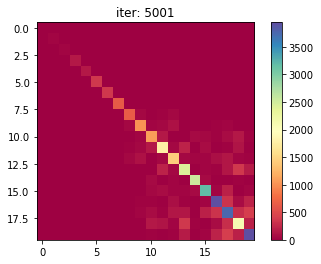

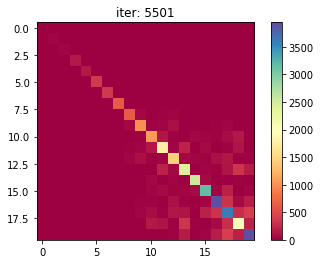

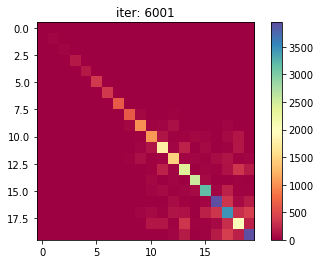

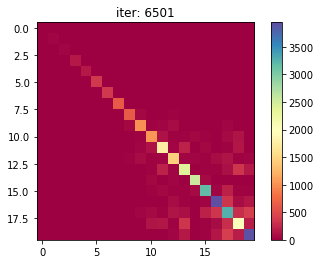

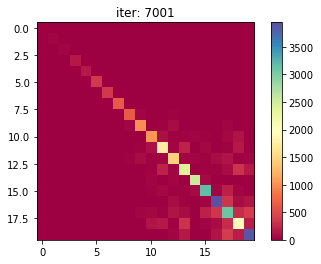

In [16]:
# hproj progress
vmax=np.max(eigs_sp)
vmin=0
for it, hp in zip(its,hps):
    Hplt = hp.cpu().detach().numpy()
    plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)
    plt.title("iter: %i" % (it+1))
    plt.colorbar()
    plt.show()

#### Animation

In [17]:
n_iter=125
n_print=1
its, errs, hps, ips, ts = utils.optimize(model, optimizer, criterion, n_iter, n_print, stop_early=False, rel_tol=0.01, patience=3, show_progress=False)

Finished Training


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


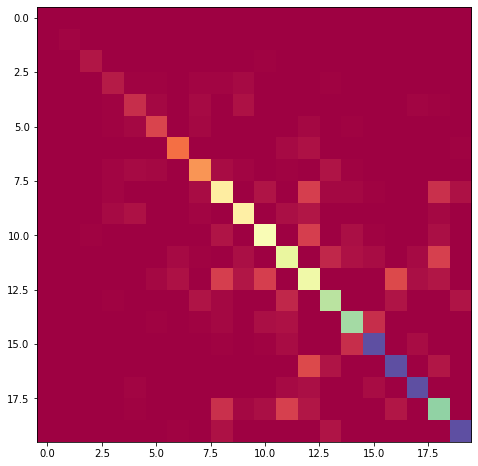

In [18]:
fig = plt.figure()
fig.set_size_inches(8,8, True)
ax = plt.axes()
vmax=np.max(eigs_sp)
vmin=0
Hplt = hps[0].cpu().detach().numpy()
mat = plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)


def init():
    mat.set_data(hps[0].cpu().detach().numpy())
    return mat,
def animate(i):
    hp = hps[i].cpu().detach().numpy()
    mat.set_data(hp)
    return mat,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(hps), interval=130, blit=True)

anim.save('diagonalization_H_ring_2particles.gif', writer='imagemagick')